In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (
    LogLocator,
    FormatStrFormatter,
)
import numpy as np
import re
import warnings

In [2]:
# Consolidate rcParams for modularity
def configure_plot_styles(for_paper):
    if for_paper:
        plt.rcParams.update(
            {
                "font.family": "Liberation Serif",
                "axes.labelsize": 8,
                "axes.titlesize": 8,
                "xtick.labelsize": 8,
                "ytick.labelsize": 8,
                "legend.fontsize": 8,
            }
        )
    else:
        plt.rcParams.update(
            {
                "font.family": "Liberation Sans",
                "axes.labelsize": 20,
                "axes.titlesize": 20,
                "xtick.labelsize": 20,
                "ytick.labelsize": 20,
                "legend.fontsize": 14,
            }
        )


configure_plot_styles(True)
figure_scale = 0.42
#figure_scale = 1.0
figsize=(8.0 * figure_scale, 6.0 * figure_scale)

In [3]:
def read_data_from_file(file_path, x_factor, y_factor, with_error=False):
    x_data, y_data, ex_data, ey_data = [], [], [], []
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith("#") or not line.strip():
                continue
            line = re.sub(r"#.*", "", line).strip()
            parts = re.split(r"[ ,]+", line)
            if len(parts) >= 2:
                try:
                    x_data.append(float(parts[0]) * x_factor)
                    y_data.append(float(parts[1]) * y_factor)
                    ex_data.append(float(parts[2]) * x_factor if len(parts) >= 4 else 0)
                    ey_data.append(float(parts[3]) * y_factor if len(parts) >= 4 else 0)
                except ValueError:
                    warnings.warn(f"Invalid data format in line: {line.strip()}")
    return x_data, y_data, ex_data, ey_data

In [4]:
def configure_axis(ax, x_label, y_label, x_scale, y_scale, x_range=None, y_range=None):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)

    if x_range:
        ax.set_xlim(x_range)
    if y_range:
        ax.set_ylim(y_range)

    if x_scale == "log":
        ax.xaxis.set_major_locator(
            LogLocator(base=10, subs=np.arange(1.0, 10.0, 1.0), numticks=100)
        )
        ax.xaxis.set_minor_locator(
            LogLocator(base=10, subs=np.arange(1.1, 10.0, 0.1), numticks=100)
        )

    ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    if y_scale == "log":
        ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1,), numticks=10))
        ax.yaxis.set_minor_locator(
            LogLocator(base=10, subs=np.arange(0.1, 1, 0.1), numticks=10)
        )
    ax.tick_params(
        axis="both",
        which="major",
        direction="in",
        length=6,  # メジャー目盛りの長さ
        width=1,
        top=True,
        right=True,
    )
    ax.tick_params(
        axis="both",
        which="minor",
        direction="in",
        length=3,  # マイナー目盛りの長さを増やす
        width=1,
        top=True,
        right=True,
    )
    ax.minorticks_on()

In [5]:
def plot_data(
    ax=None,
    file_infos=None,
    error_file_infos=None,
    fill_files=None,
    x_range=None,
    y_range=None,
    draw_arrow=False,
    x_label="",
    y_label="",
    x_scale="linear",
    y_scale="linear",
    fill_label="fill label",
    foutname="",
    y_legend_offset=0.5,
    fig_size=(8, 6),
    frameon=True,
):
    if ax is None:
        plt.figure(figsize=fig_size)
        ax = plt.gca()

    markers, linestyles = ["o", "D", "^", "*", "+", "x", "s"], ["-", "--", "-.", ":"]

    # Plot main data
    if file_infos:
        for i, file_info in enumerate(file_infos):
            path, x_factor, y_factor, description, color = file_info
            x_data, y_data, _, _ = read_data_from_file(path, x_factor, y_factor)
            ax.plot(
                x_data,
                y_data,
                linewidth=1,
                linestyle=linestyles[i % len(linestyles)],
                color=color,
                label=description,
            )

    # Plot error data
    if error_file_infos:
        for i, error_file_info in enumerate(error_file_infos):
            path, x_factor, y_factor, description, color = error_file_info
            x_data, y_data, ex_data, ey_data = read_data_from_file(path, x_factor, y_factor)
            ax.errorbar(
                x_data,
                y_data,
                xerr=ex_data,
                yerr=ey_data,
                fmt=markers[i % len(markers)],
                color=color,
                ecolor="black",
                markersize=3,
                elinewidth=1,
                capsize=2,
                label=description,
            )

    # Plot filled area for confidence intervals
    for num, files in enumerate(fill_files):
      if files and len(files) == 2:
          fill_x_datas, fill_y_datas = [], []
          for file in files:
              path, x_factor, y_factor, _ = file
              x_data, y_data, _, _ = read_data_from_file(path, x_factor, y_factor)
              fill_x_datas.append(x_data)
              fill_y_datas.append(y_data)
          colors = [(0.8, 0.9, 1), (0.8, 0.9, 0.75)]
          ax.fill_between(
              fill_x_datas[0],
              fill_y_datas[0],
              fill_y_datas[1],
              color=colors[num],
              label=fill_label,
          )

    configure_axis(ax, x_label, y_label, x_scale, y_scale, x_range, y_range)

    if draw_arrow:
        step = np.exp(np.log(y_range[1] / y_range[0]) / 100.0) # 100 steps
        for x1, x2, text, ystep in [
            (1.21, 2.21, r"$T_9 = 1.0$", 28),
            (1.80, 3.51, r"$T_9 = 2.0$", 23),
            (2.24, 4.45, r"$T_9 = 3.0$", 18),
            (2.57, 5.16, r"$T_9 = 4.0$", 13),
            (2.83, 5.74, r"$T_9 = 5.0$", 8),
        ]:
            ypos = y_range[0] * step**ystep
            ax.annotate(
                "",
                xy=(x1, ypos),
                xytext=(x2, ypos),
                arrowprops=dict(arrowstyle="<->", lw=0.5, color="black"),
            )
            ax.text(x2 + 0.4, ypos / (step**2), text, fontsize=5, color="black", ha="center")

    ax.legend(
        fontsize=6,
        loc="center right",
        bbox_to_anchor=(1.0, y_legend_offset),
        facecolor="white",
        framealpha=1,
        edgecolor="white",
        frameon=frameon,
    )
    if not ax:
        plt.savefig(f"{foutname}.eps", format="eps", bbox_inches="tight")
        plt.savefig(f"{foutname}.png", format="png", dpi=300, bbox_inches="tight")
        plt.show()

In [6]:
factor = 25.9846537 / (25.9846537 + 4.00150609413)  # Lab -> CM

# (path, x_factor, y_factor, description)
file_infos = [
    ("txt/nonsmoker.txt", 1.0, 1.0e3, "NON-SMOKER", "r"),
    # ("txt/binary_ap.tot", factor, 1.0, "TALYS total\n(discrete + continuum)"),
    # ("txt/binary_ap.tot", factor, 1.0e-1, "TALYS total x 0.1"),
    ("txt/nonsmoker.txt", 1.0, 1.0e3 * 0.14114, r"NON-SMOKER $\times$ 0.14", "b"),
    # ("txt/nonsmoker.txt", 1.0, 1.0e2, "NONSMOKER x 0.1"),
    # ("txt/nonsmoker.txt", 1.0, 1.0e1, "NONSMOKER x 0.01"),
    # ("txt/ap.L00", factor, 1.0, r"TALYS ($\alpha,~p_0$)"),
    ("txt/ap.L01", factor, 1.0, r"TALYS ($\alpha,~p_1$)", "black"),
    ("txt/ap.L10", factor, 1.0, r"TALYS ($\alpha,~p_{10}$)", "black"),
    # ("txt/ap.L11", factor, 1.0, r"TALYS ($\alpha,~p_{11}$)"),
    # ("txt/ap.L12", factor, 1.0, r"TALYS ($\alpha,~p_{12}$)"),
    # ("txt/ap.L13", factor, 1.0, r"TALYS ($\alpha,~p_{13}$)"),
    # ("txt/ap.L14", factor, 1.0, r"TALYS ($\alpha,~p_{14}$)"),
    # ("txt/ap.L20", factor, 1.0, r"TALYS ($\alpha,~p_{20}$)"),
    # ("txt/ap.L30", factor, 1.0, r"TALYS ($\alpha,~p_{30}$)"),
    # ("txt/ap.L40", factor, 1.0, r"TALYS ($\alpha,~p_{40}$)"),
    # ("txt/rp014028.tot", factor, 1.0, r"TALYS ($\alpha,~2p$)"),
]

error_file_infos = [
    ("txt/present_40.txt", 1.0, 1.0, "present data", "black"),
    # ("result/ground2.txt", 1.0, 1.0e3, r"present data2 ($\alpha, p_0$)"),
    # ("result/random_all.txt", 1.0, 1.0e3, r"present data (random)"),
    # (
    #    "result/random2.txt",
    #    1.0,
    #    1.0e3,
    #    # "present data with stochastic\n" r"($\alpha,~p_{0-10}$) assignments",
    #    "present data",
    # ),
]

fill_files = [
    [
        ("txt/nonsmoker.txt", 1.0, 1.0e3 * 0.04791, "NONSMOKER x 0.1"),
        ("txt/nonsmoker.txt", 1.0, 1.0e3 * 0.23424, "NONSMOKER x 0.01"),
    ]
]

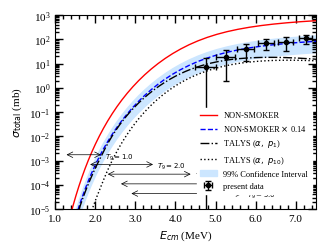

In [7]:
plot_data(
    ax=None,
    file_infos=file_infos,
    error_file_infos=error_file_infos,
    fill_files=fill_files,
    x_range=(1.0, 7.5),
    y_range=(1.0e-5, 1.0e+3),
    x_scale="linear",
    y_scale="log",
    draw_arrow=True,
    x_label=r"$E_{cm}$ (MeV)",
    y_label=r"$\sigma_{\rm{total}}$ (mb)",
    foutname="figure/cs/cross_section",
    fill_label="99% Confidence Interval",
    y_legend_offset=0.3,
    fig_size=figsize,
)

In [8]:
file_infos_rate = [
    ("txt/reaclib.txt", 1.0, 1.0, "NON-SMOKER (reaclib)", "r"),
    ("txt/reaclib.txt", 1.0, 1.0 * 0.141, r"NON-SMOKER $\times$ 0.14", "g"),
    ("txt/previous.txt", 1.0, 1.0, "Almaraz-Calderon et al.", "b"),
]

fill_files_rate = [
    [
        ("txt/previous.txt", 1.0, 1.0e1, "upper"),
        ("txt/previous.txt", 1.0, 1.0e-1, "lower"),
    ],
    [
        ("txt/reaclib.txt", 1.0, 1.0 * 0.04791, "NONSMOKER x 0.1"),
        ("txt/reaclib.txt", 1.0, 1.0 * 0.23424, "NONSMOKER x 0.01"),
    ],
]

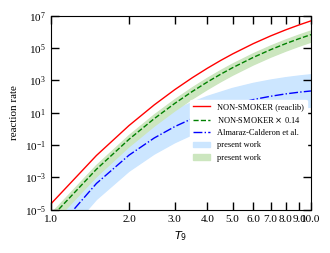

In [9]:
plot_data(
    ax=None,
    file_infos=file_infos_rate,
    error_file_infos=None,
    fill_files=fill_files_rate,
    x_range=(1.0, 10.0),
    y_range=(1.0e-5, 1.0e7),
    x_scale="log",
    y_scale="log",
    draw_arrow=False,
    x_label=r"$T_{9}$",
    y_label=r"reaction rate",
    foutname="figure/cs/reaction_rate",
    fill_label="present work",
    y_legend_offset=0.4,
    fig_size=figsize,
)

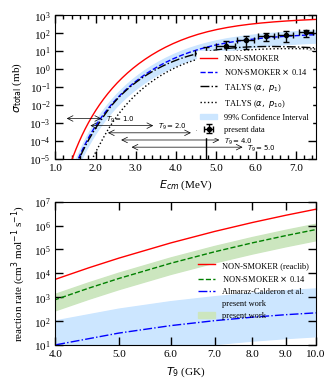

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figsize[0], figsize[1] * 1.7))

plot_data(
    ax=ax1,
    file_infos=file_infos,
    error_file_infos=error_file_infos,
    fill_files=fill_files,
    x_range=(1.0, 7.5),
    y_range=(1.0e-5, 1.0e3),
    x_scale="linear",
    y_scale="log",
    draw_arrow=True,
    x_label=r"$E_{cm}$ (MeV)",
    y_label=r"$\sigma_{\rm{total}}$ (mb)",
    foutname="figure/cs/cross_section",
    fill_label="99% Confidence Interval",
    y_legend_offset=0.45,
)

plot_data(
    ax=ax2,
    file_infos=file_infos_rate,
    error_file_infos=None,
    fill_files=fill_files_rate,
    x_range=(4.0, 10.0),
    y_range=(1.0e1, 1.0e7),
    x_scale="log",
    y_scale="log",
    draw_arrow=False,
    x_label=r"$T_{9}$ (GK)",
    y_label=r"reaction rate (cm$^3$ mol$^{-1}$ s$^{-1}$)",
    foutname="figure/cs/reaction_rate",
    fill_label="present work",
    y_legend_offset=0.38,
    frameon=False,
)
# レイアウト調整
plt.subplots_adjust(hspace=0.3)
#plt.tightlayout()
plt.savefig(f"figure/cs/cs_with_rate.eps", format="eps", bbox_inches="tight")
plt.savefig(f"figure/cs/cs_with_rate.png", format="png", dpi=300, bbox_inches="tight")
plt.show()